In [198]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import numpy as np
import calendar
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
article_id = 14096681 
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "figshareaustralia/"

response = requests.request("GET", url, headers=headers)
data = json.loads(response.text) 
files = data["files"]             
files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26766812',
  'supplied_md5': 'b517383f76e77bd03755a63a8f

In [5]:
%%time
files_to_dl = ["data.zip"] 
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: total: 12.9 s
Wall time: 58min 36s


In [6]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

CPU times: total: 44.8 s
Wall time: 45 s


In [12]:
%%sh
ls -ltr figshareaustralia/

total 6016504
-rw-r--r-- 1 plevc 197609 814041183 Mar 28 14:10 data.zip
-rw-r--r-- 1 plevc 197609  95376895 Mar 28 14:10 MPI-ESM-1-2-HAM_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609  94960113 Mar 28 14:10 AWI-ESM-1-1-LR_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609  82474546 Mar 28 14:10 NorESM2-LM_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609 127613760 Mar 28 14:10 ACCESS-CM2_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609 232118894 Mar 28 14:10 FGOALS-f3-L_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609 330360682 Mar 28 14:10 CMCC-CM2-HR4_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609 254009247 Mar 28 14:10 MRI-ESM2-0_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609 235661418 Mar 28 14:10 GFDL-CM4_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609 294260911 Mar 28 14:10 BCC-CSM2-MR_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609 295768615 Mar 28 14:10 EC-Earth3-Veg-LR_daily_rainfall_NSW.csv
-rw-r--r-- 1 plevc 197609 328852379 Mar 28 14:10 CMCC-ESM2_daily_rainfall_NSW.csv

In [10]:
%%time
files = glob.glob('figshareaustralia/*.csv')
files.remove('figshareaustralia\\observed_daily_rainfall_SYD.csv')

df = pd.concat((pd.read_csv(file, index_col=0)
                .assign(model=file.split('\\')[1].split('_daily')[0])
                for file in files)
              )
df.to_csv("figshareaustralia/combined_data.csv")

CPU times: total: 18min 32s
Wall time: 18min 39s


In [118]:
df = pd.read_csv("figshareaustralia/combined_data.csv")

#### Size of original dataframe

In [119]:
df.shape

(62467843, 7)

#### Initial number of models

In [120]:
len(df['model'].unique())

27

#### Exploring for NaN values

In [121]:
dfna = df[df.isnull().any(axis=1)]
dfna.shape

(3219300, 7)

_As can be seen from the result above, rougly 5% of observations have missing data. That amount is not that large, while exploring proper ways for imputation will take a lot of efforts, so for the first path we will just ignore all those observations with missing values_

In [126]:
df = df.dropna()

#### Number of models after removing NaN values

In [123]:
len(df['model'].unique())

26

_It means that we removed one model completely as it had too many missing values_

#### Size of dataframe without NaN values

In [127]:
df.shape

(59248543, 7)

### Visualisation of areal coverage by model

_Grouping by minimum and maximum values_

In [61]:
dfmin = (df.groupby(by = "model")
         .min()
         .reset_index()
         .drop(columns=['time', 'lat_max', 'lon_max'])
         .rename(columns={"rain (mm/day)": "min rain"})
        )
dfmax = (df.groupby(by = "model")
         .max()
         .reset_index()
         .drop(columns=['time', 'lat_min', 'lon_min'])
         .rename(columns={"rain (mm/day)": "max rain"})
        )
dfg = dfmin.merge(dfmax, on="model")
dfg.head(3)

#### Plots for longitude and latitude ranges

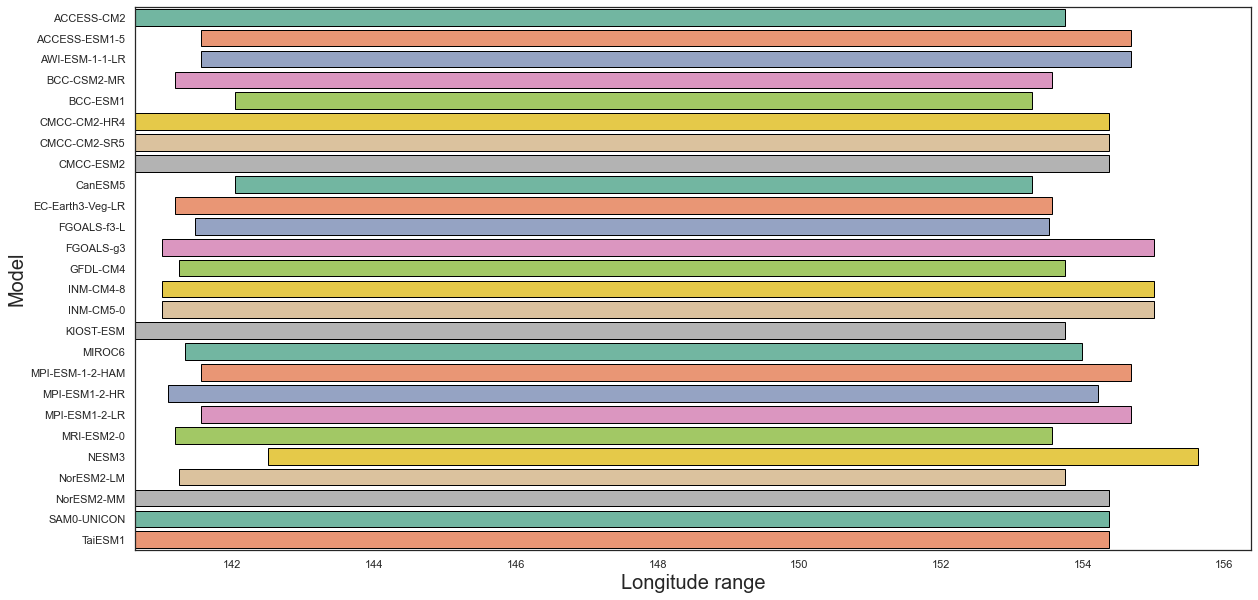

In [269]:
sns.set(rc={'figure.figsize':(20,10),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white") 
ax = sns.barplot(x=dfg['lon_max']-dfg['lon_min'], 
                 y=dfg["model"].unique(), 
                 left=dfg['lon_min'],
                 palette="Set2", 
                 ec='black')
ax.set_xlabel('Longitude range') 
ax.set_ylabel('Model');

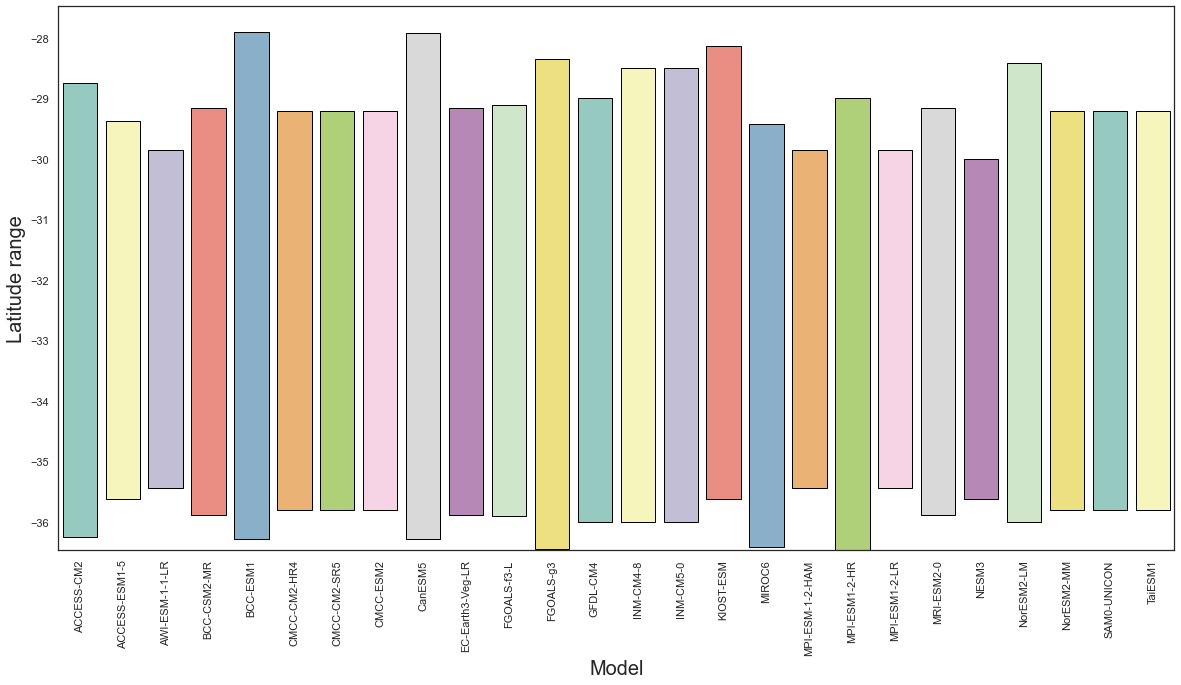

In [268]:
sns.set(rc={'figure.figsize':(20,10),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white") 
ax = sns.barplot(x=dfg["model"].unique(), 
                 y=dfg['lat_max']-dfg['lat_min'], 
                 bottom=dfg['lat_min'],
                 palette='Set3', 
                 ec='black')
ax.set_xlabel('Model') 
ax.set_ylabel('Latitude range')
plt.xticks(rotation=90);

#### Distribution of values for amount of rain

_Based on observations at several models, variable "rain (mm/day)" has a long tail in distribution with a lot of outliers. Plotting that data with violin plots is extremely computationaly intensive, so we will just compare those distribution with boxplots with making prior logarithmic transformation_

In [130]:
df['log_rain'] = np.log1p(df['rain (mm/day)'])

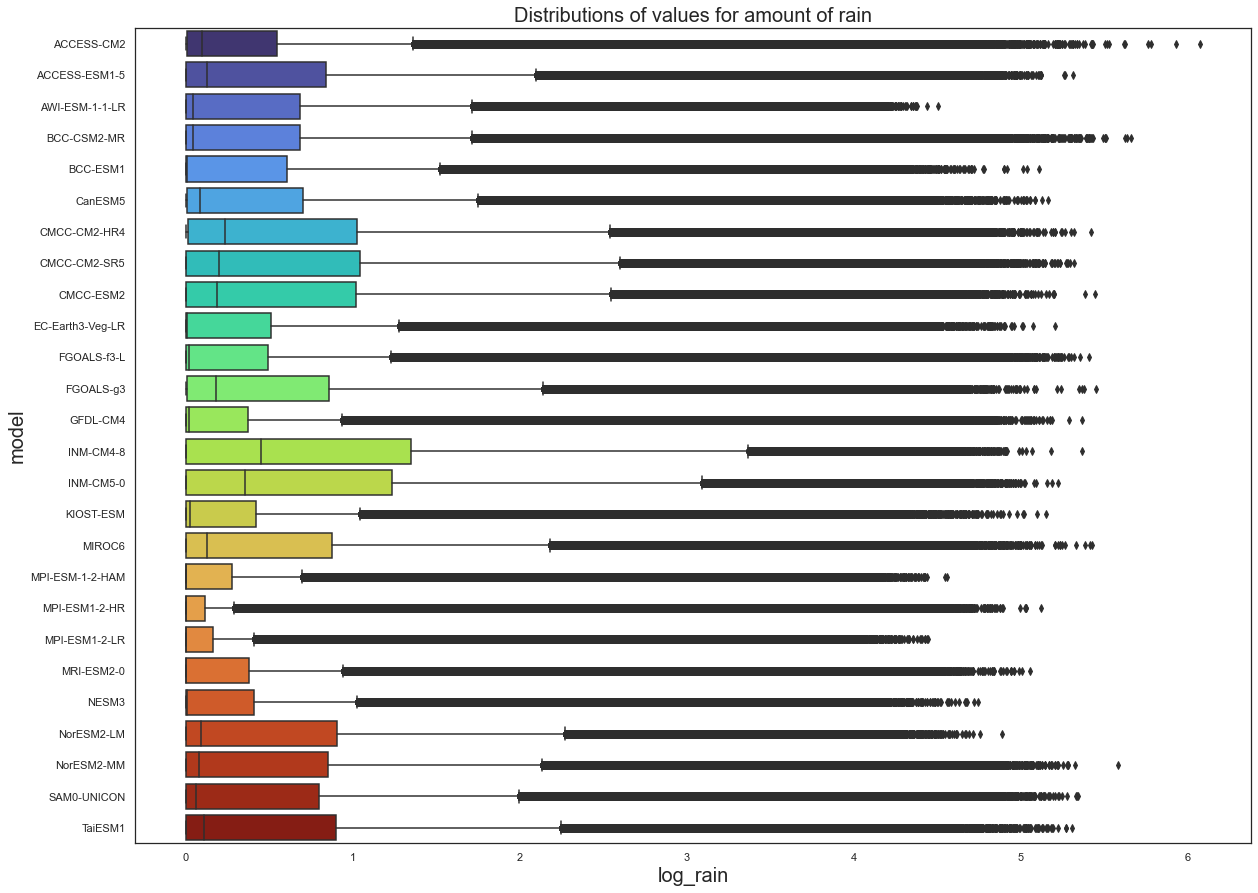

In [270]:
sns.set(rc={'figure.figsize':(20,15),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white") 
sns.boxplot(data = df, x="log_rain", y="model", palette='turbo').set_title('Distributions of values for amount of rain'); 

#### Seasonal distribution of rain amount

_In order to simplify visualisations, we will lump together rain data collected during one of the months. This also alleviates some problem with outliers seen before, making plots more meaningful for comparison_

In [232]:
df['time'] = pd.to_datetime(df['time'])
models = df['model'].unique()
num_models = len(models)

columns = df.columns.to_list()
columns.append('month')
dfm = pd.DataFrame(columns = columns)

for model in df['model'].unique():
    dfmod = df[df['model']==model]
    dfmod = (dfmod.set_index('time')
               .resample('M')
               .mean()
               .reset_index()
               .assign(model = model)
              )
    dfmod['month'] = dfmod['time'].apply(lambda x: x.strftime('%B')) 
    dfm = pd.concat([dfm, dfmod]) 

In [234]:
dfm.shape

(39312, 9)

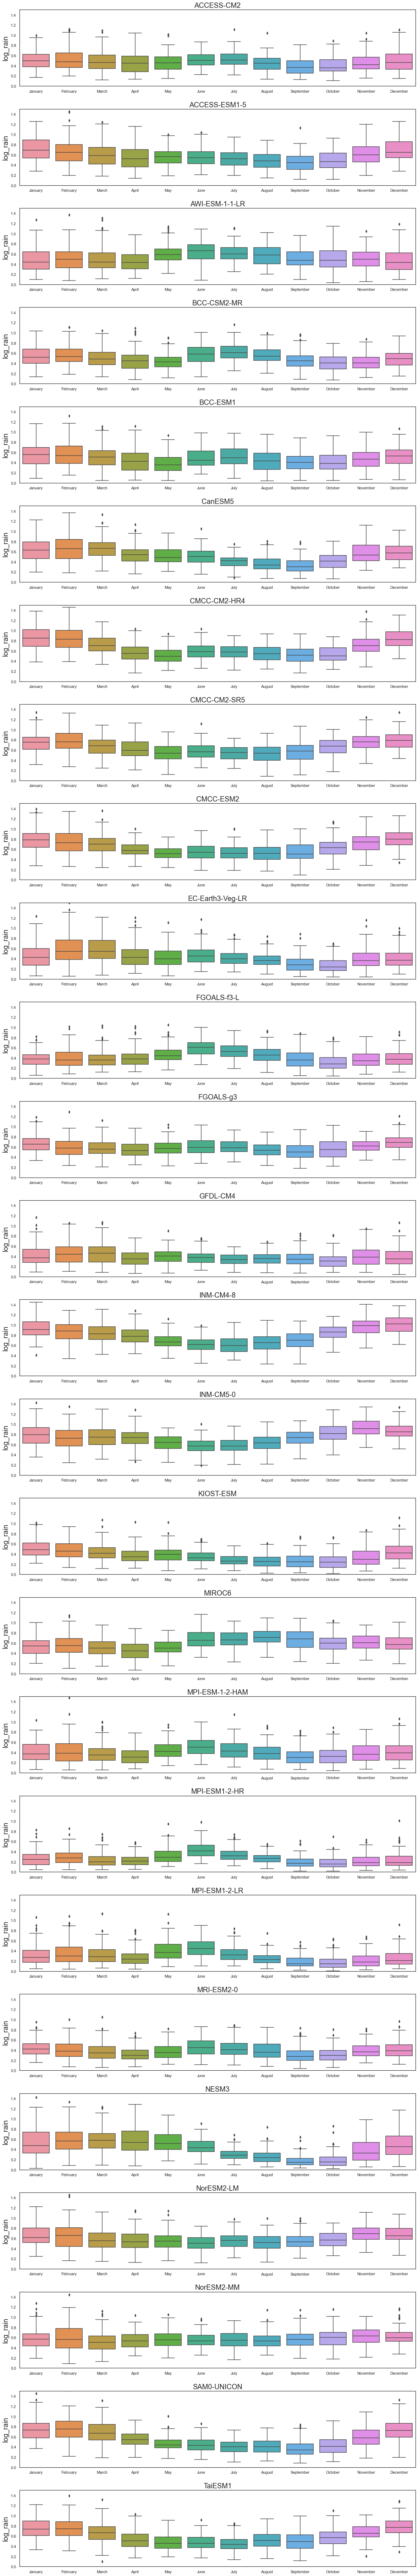

In [254]:
sns.set(rc={'figure.figsize':(20,100),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white") 
fig, axes = plt.subplots(num_models, 1)
plt.subplots_adjust(left=None, bottom=0.5, right=None, top=1.5, wspace=None, hspace=0.3)

for i in range(num_models):
    model = models[i]
    dfmod = dfm[dfm['model']==model]
    sns.boxplot(ax=axes[i], data=dfmod, x="month", y="log_rain").set_title(model) 
    axes[i].set_xlabel("")
    axes[i].set(ylim=(0, 1.5))

<br>

_Same seasonal plots but showing results of different models side by side_

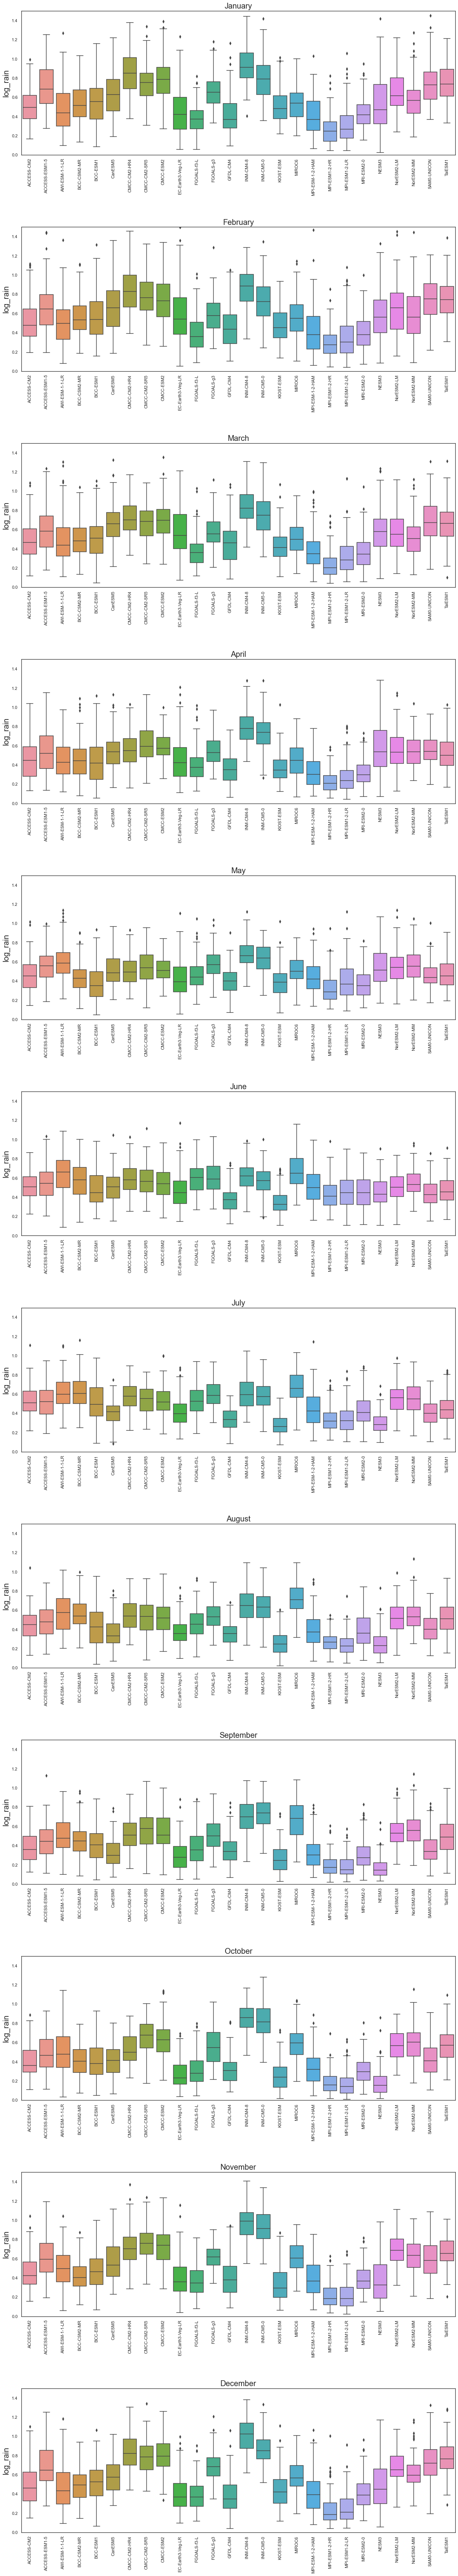

In [248]:
months = list(calendar.month_name)[1:]
num_months = len(months)
sns.set(rc={'figure.figsize':(20,60),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white") 
fig, axes = plt.subplots(num_months, 1)
plt.subplots_adjust(left=None, bottom=0.5, right=None, top=2, wspace=None, hspace=0.5)

for i in range(num_months):
    month = months[i]
    dfmon = dfm[dfm['month']==month]
    sns.boxplot(ax=axes[i], data=dfmon, x="model", y="log_rain").set_title(month) 
    axes[i].set_xlabel("")
    axes[i].set(ylim=(0, 1.5))
    axes[i].tick_params(axis='x', rotation=90);

<br>
<br>

### Converting dataframes to parquet

In [272]:
df.to_parquet("figshareaustralia/combined_data.parquet")
dfm.to_parquet("figshareaustralia/monthly_aggregation.parquet")

<br>
<br>

### EDA in R

In [273]:
%load_ext rpy2.ipython

C:\Users\plevc\miniconda3\envs\525\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [274]:
%%R
suppressMessages(library(data.table))
suppressMessages(library(dplyr))
dfr <- fread("figshareaustralia/combined_data.csv", showProgress = FALSE)

In [276]:
%%R
dfr

                         time   lat_min   lat_max lon_min lon_max rain (mm/day)
       1: 1889-01-01 12:00:00 -36.25000 -35.00000 140.625 142.500  3.293256e-13
       2: 1889-01-02 12:00:00 -36.25000 -35.00000 140.625 142.500  0.000000e+00
       3: 1889-01-03 12:00:00 -36.25000 -35.00000 140.625 142.500  0.000000e+00
       4: 1889-01-04 12:00:00 -36.25000 -35.00000 140.625 142.500  0.000000e+00
       5: 1889-01-05 12:00:00 -36.25000 -35.00000 140.625 142.500  1.047658e-02
      ---                                                                      
62467839: 2014-12-27 12:00:00 -30.15707 -29.21466 153.125 154.375  5.543748e-01
62467840: 2014-12-28 12:00:00 -30.15707 -29.21466 153.125 154.375  7.028577e+00
62467841: 2014-12-29 12:00:00 -30.15707 -29.21466 153.125 154.375  2.347570e-01
62467842: 2014-12-30 12:00:00 -30.15707 -29.21466 153.125 154.375  2.097459e+00
62467843: 2014-12-31 12:00:00 -30.15707 -29.21466 153.125 154.375  5.484206e-01
               model
       1: ACCESS-CM